In [24]:
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [25]:
image = Image.open("img3.png")

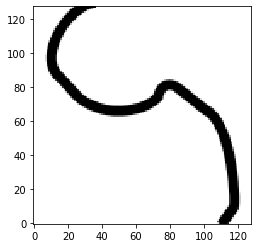

In [26]:
image_to_array = np.asarray(image)
plt.imshow(image_to_array, origin="lower")
plt.show()

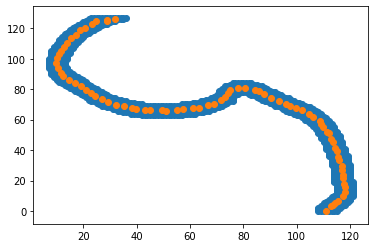

In [55]:
# n_max = 50
# step = 1
# img_mtx = np.copy(image_to_array[:, :, 0])
# while len(np.where(img_mtx[:, :]!=255)[0]) > n_max:
#     img_mtx = img_mtx.reshape(img_mtx.shape[0]//2, 2, img_mtx.shape[1]//2, 2).mean(axis=(1,3))
# y = np.where(img_mtx!=255)[0]
# x = np.where(img_mtx!=255)[1]
# plt.scatter(x, y)

max_distance = 10

img_mtx = np.copy(image_to_array[:, :, 0])
y, x = np.where(img_mtx!=255)
idx_list = list(zip(y, x))
ordered_idx = []

# starting point y=0
x0 = int(np.mean(np.where(img_mtx[0, :] != 255)))
point = (0, x0)
idx_list.remove(point)
ordered_idx.append(point)
point = np.array(point)
# ending point x=128
while point[0] < 128 - 0.25 * max_distance:
    idx_mtx = np.array(idx_list)
    distance = np.mean((idx_mtx - point) ** 2, axis=1)
    condition = (distance < max_distance * 1.5) & (distance > max_distance * 0.5)
    point_idx = idx_mtx[condition].mean(axis=0)
    point = tuple(point_idx)
    ordered_idx.append(point)
    idx_to_remove = idx_mtx[condition]
    for i in range(idx_to_remove.shape[0]):
        idx_list.remove(tuple(idx_to_remove[i]))
    try:
        idx_list.remove(point)
    except:
        pass
    point = np.array(point)


ordered_idx = np.array(ordered_idx)
x_new = ordered_idx[:, 1]
y_new = ordered_idx[:, 0]
plt.scatter(x, y)
plt.scatter(x_new, y_new)


In [56]:
# y = np.arange(img_mtx.shape[0])
# x = np.array([np.mean(np.where(img_mtx[y_i, :, 0]!=255)[0]) for y_i in y])
# t
# plt.plot(y, x)
# # Check for nans
# while len(x[x!=x]):
#     nan_idx = np.where(x!=x)[0]
#     i = 0
#     while i < len(nan_idx) - 1 and nan_idx[i] == nan_idx[i + 1] - 1:
#         i += 1
#     nan_idx = np.array(nan_idx[:i + 1])
#     x[nan_idx] = x[nan_idx[0]-1] +\
#                 (x[nan_idx[-1] +1 ] - x[nan_idx[0] - 1]) / (len(nan_idx)) * np.arange(len(nan_idx))

In [57]:
# evaluate the Chebyshev polynomial T of order n in t (t in the interval [-1, 1])
def T(n, t):
    if n == 0:
        return 1
    if n == 1:
        return t
    return 2 * t * T(n-1, t) - T(n-2, t)

# evaluate the coefficient c
# c is the projection of f over the Chebyshev polynomial T_k (of order k) 
# given N, the order of the approximation
def c(k, N, f):
    # build the grid
    t_range = np.cos(np.arange(0, N + 1) * np.pi / N)
    # take only the points of f on the grid
    f_points = f[((len(f) -1) * (t_range + 1) / 2).astype(np.int)]
    f_points[f_points != f_points] = 0
    # evaluate the weight
    w = 2/N
    # initialize the coefficient
    c = 0
    
    # evaluate the coefficient
    for j, t_j in enumerate(t_range):
        if j == N or j == 0:
            c += w*f_points[j]*T(k, t_j)/2

        else:
            c += w*f_points[j]*T(k, t_j)
    # return the coefficient
    if k==0 or k==N:
        return c/2
    return c

# evaluate P, the Chebyshev polynomial interpolating f, in t (t in the interval [-1, 1])
# where N is the order of the approximation
def P_cheb(f, N, t):
    P = 0
    for n in range(0, N+1):
        P += T(n,t)*c(n, N, f)
    return P


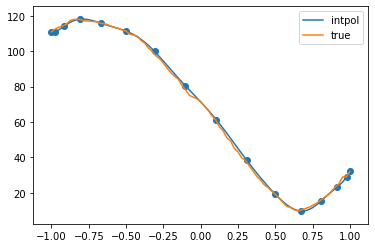

In [58]:
t = np.linspace(-1, 1, len(x_new))
N = 15 # choose order of the interpolating polynomial
x_intpol = P_cheb(x_new, N, t)
plt.plot(t, x_intpol, label="intpol")
plt.plot(t, x_new, label="true")
t_range = np.cos(np.arange(0, N + 1) * np.pi / N)
plt.scatter(t_range, x_new[((len(x_new) -1) * (t_range + 1) / 2).astype(np.int)])
plt.legend()
plt.show()

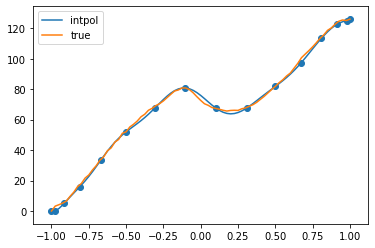

In [59]:
y_intpol = P_cheb(y_new, N, t)
plt.plot(t, y_intpol, label="intpol")
plt.plot(t, y_new, label="true")
t_range = np.cos(np.arange(0, N + 1) * np.pi / N)
plt.scatter(t_range, y_new[((len(y_new) -1) * (t_range + 1) / 2).astype(np.int)])
plt.legend()
plt.show()

In [62]:
result = np.zeros([128, 128])
for j, y_j in enumerate(y_intpol):
    result[int(y_j), int(x_intpol[j])] = 1

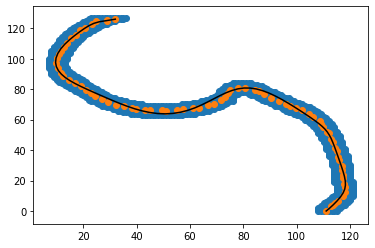

In [63]:
plt.scatter(x, y)
plt.scatter(x_new, y_new)
plt.plot(x_intpol, y_intpol, c="k")
#plt.scatter(x_intpol, y_intpol)

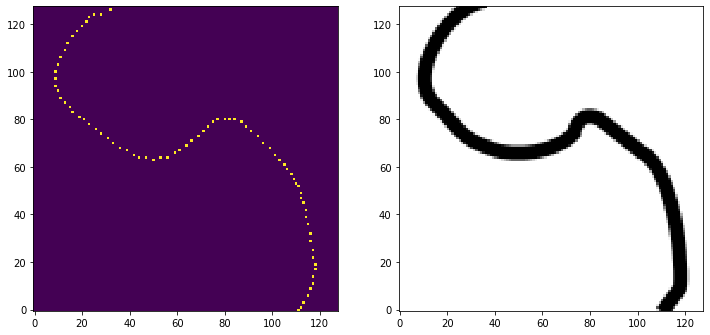

In [64]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(result, origin="bottom")
plt.subplot(1, 2, 2)
plt.imshow(image_to_array, origin="bottom")